In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('train_intro.csv')
df.head()

,Unnamed: 0,Stock1,Stock2,Stock3,Stock4,Stock1_Delay,Stock2_Delay,Stock3_Delay,Stock4_Delay
0,0,1479.36,1088.26,1545.61,1304.27,1481.40,1094.60,1546.06,1347.49
1,1,1479.33,1087.03,1544.94,1305.82,1479.36,1088.26,1545.61,1304.27
2,2,1479.72,1087.16,1543.55,1287.43,1479.33,1087.03,1544.94,1305.82
3,3,1477.47,1077.92,1545.35,1193.67,1479.72,1087.16,1543.55,1287.43
4,4,1474.91,1076.45,1545.01,1296.92,1477.47,1077.92,1545.35,1193.67


In [3]:
# add returns columns for each stock
for stock in ['Stock1', 'Stock2', 'Stock3', 'Stock4', 'Stock1_Delay', 'Stock2_Delay', 'Stock3_Delay', 'Stock4_Delay']:
    df[stock + '_Return'] = df[stock].pct_change()


# # IMPORTANT: Shift non-delayed returns forward by 1 day (model the 1-delay)
# df['Stock1_Return'] = df['Stock1_Return'].shift(-1)
# df['Stock2_Return'] = df['Stock2_Return'].shift(-1)
# df['Stock3_Return'] = df['Stock3_Return'].shift(-1)
# df['Stock4_Return'] = df['Stock4_Return'].shift(-1)

df.replace(np.nan, 0, inplace=True)

df.head()

,Unnamed: 0,Stock1,Stock2,Stock3,Stock4,Stock1_Delay,Stock2_Delay,Stock3_Delay,Stock4_Delay,Stock1_Return,Stock2_Return,Stock3_Return,Stock4_Return,Stock1_Delay_Return,Stock2_Delay_Return,Stock3_Delay_Return,Stock4_Delay_Return
0,0,1479.36,1088.26,1545.61,1304.27,1481.40,1094.60,1546.06,1347.49,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,1479.33,1087.03,1544.94,1305.82,1479.36,1088.26,1545.61,1304.27,-0.000020,-0.001130,-0.000433,0.001188,-0.001377,-0.005792,-0.000291,-0.032074
2,2,1479.72,1087.16,1543.55,1287.43,1479.33,1087.03,1544.94,1305.82,0.000264,0.000120,-0.000900,-0.014083,-0.000020,-0.001130,-0.000433,0.001188
3,3,1477.47,1077.92,1545.35,1193.67,1479.72,1087.16,1543.55,1287.43,-0.001521,-0.008499,0.001166,-0.072827,0.000264,0.000120,-0.000900,-0.014083
4,4,1474.91,1076.45,1545.01,1296.92,1477.47,1077.92,1545.35,1193.67,-0.001733,-0.001364,-0.000220,0.086498,-0.001521,-0.008499,0.001166,-0.072827


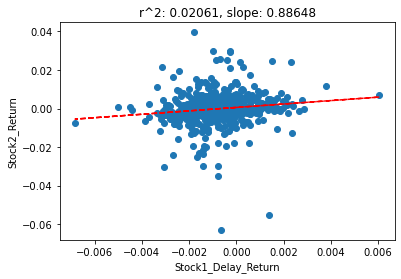

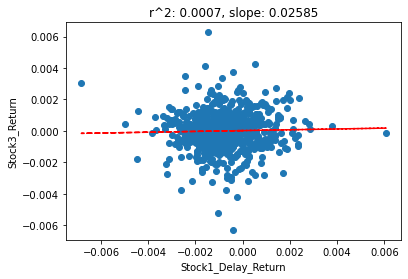

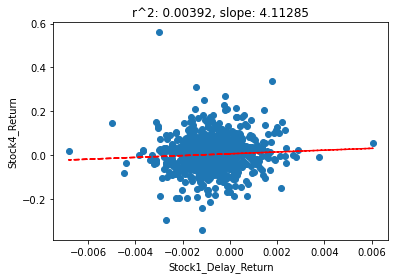

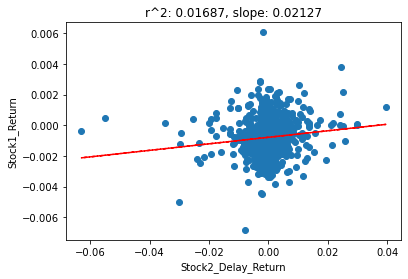

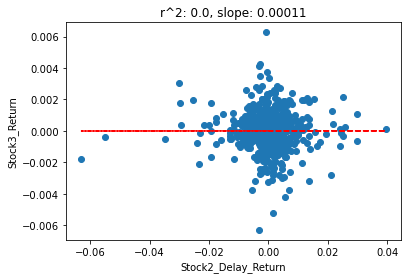

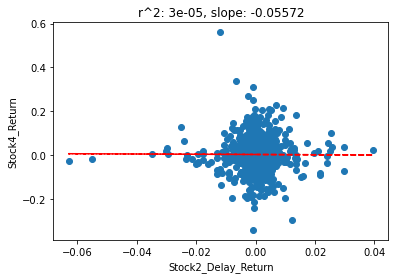

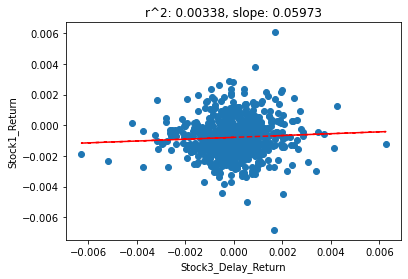

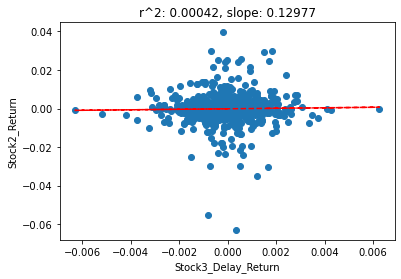

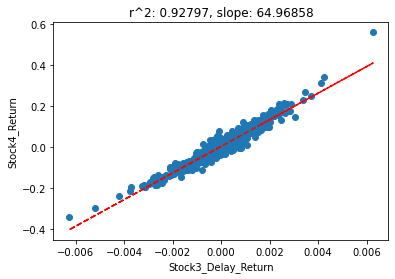

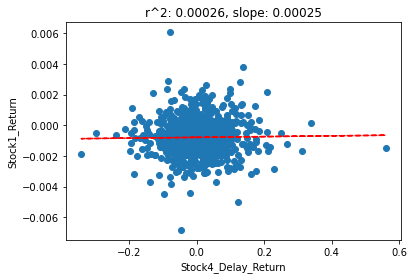

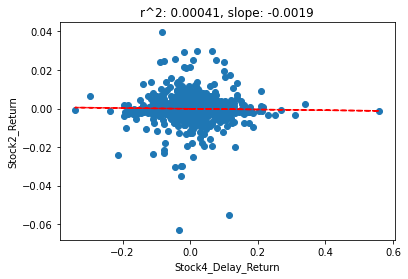

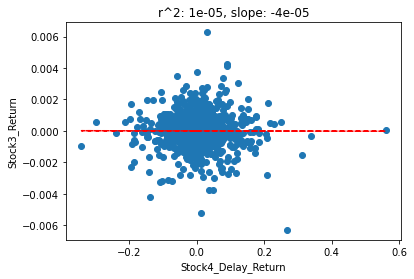

In [4]:
import matplotlib.pyplot as plt

for stock1 in ['Stock1_Delay_Return', 'Stock2_Delay_Return', 'Stock3_Delay_Return', 'Stock4_Delay_Return']:
    for stock2 in ['Stock1_Return', 'Stock2_Return', 'Stock3_Return', 'Stock4_Return']:
        if stock1[:6] != stock2[:6]:
            # # drop outliers
            # df = df[(np.abs(df[stock1] - df[stock1].mean()) <= (3 * df[stock1].std()))]
            # df = df[(np.abs(df[stock2] - df[stock2].mean()) <= (3 * df[stock2].std()))]
            # plot
            plt.scatter(df[stock1], df[stock2])
            plt.xlabel(stock1)
            plt.ylabel(stock2)
            # trend-line
            z = np.polyfit(df[stock1], df[stock2], 1)
            p = np.poly1d(z)
            plt.plot(df[stock1],p(df[stock1]),"r--")
            # set title to r^2 value, slope
            plt.title(f'r^2: {round(np.corrcoef(df[stock1], df[stock2])[0, 1] ** 2, 5)}, slope: {round(z[0], 5)}')
        plt.show()


In [5]:
from sklearn.model_selection import train_test_split

# 1 deg polynomial for stock 1, 2, 3, 4 onto each other
poly = PolynomialFeatures(degree=1)

# test each of the 3 stocks to predict the last one
delays = ['Stock1_Delay_Return', 'Stock2_Delay_Return', 'Stock3_Delay_Return', 'Stock4_Delay_Return']
labels = ['Stock1_Return', 'Stock2_Return', 'Stock3_Return', 'Stock4_Return']
for to_remove in range(len(delays)):
    X = poly.fit_transform(df[[delays[i] for i in range(len(delays)) if i != to_remove]])
    y = df[labels[to_remove]]
    X_train, X_test = train_test_split(X, test_size=0.2)
    y_train, y_test = train_test_split(y, test_size=0.2)
    model = LinearRegression()
    model.fit(X_train, y_train)
    print(f'Stock {to_remove + 1}:', model.score(X_train, y_train))
    print(f'Coefficients: {model.coef_}')

Stock 1: 0.003915928957393344
Coefficients: [ 0.          0.00698009 -0.00264068 -0.00064192]
Stock 2: 0.002910157466636698
Coefficients: [0.         0.23595809 0.15219736 0.00167046]
Stock 3: 0.0008037382318267783
Coefficients: [ 0.         -0.01484187  0.00098852 -0.00034981]
Stock 4: 0.0016313525279914032
Coefficients: [ 0.         -1.16972577 -0.33070845  0.4482441 ]


In [6]:
# linear/polynomial models seem useless... let's try a random forest regressor

In [7]:
from sklearn.model_selection import train_test_split
# now do the exact same experiment but with a randon forest regressor
from sklearn.ensemble import RandomForestRegressor

# test each of the 3 stocks to predict the last one
delays = ['Stock1_Delay_Return', 'Stock2_Delay_Return', 'Stock3_Delay_Return', 'Stock4_Delay_Return']
labels = ['Stock1_Return', 'Stock2_Return', 'Stock3_Return', 'Stock4_Return']
for to_remove in range(len(delays)):
    # test train split
    X = df[[delays[i] for i in range(len(delays)) if i != to_remove]]
    X_train, X_test = train_test_split(X, test_size=0.2)
    y_train, y_test = train_test_split(df[labels[to_remove]], test_size=0.2)
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    print(f'Stock {to_remove + 1}:', model.score(X_test, y_test))
    print(f'Feature importances: {model.feature_importances_}')



Stock 1: -0.0870651314420905
Feature importances: [0.34292217 0.32254407 0.33453376]
Stock 2: -0.2371961910430178
Feature importances: [0.35751117 0.34391882 0.29857001]
Stock 3: -0.16889324816328655
Feature importances: [0.33464054 0.29743367 0.36792579]
Stock 4: -0.12287005823866348
Feature importances: [0.35799661 0.31077107 0.33123232]


In [8]:
# much better!

#save forest
import pickle
for to_remove in range(len(delays)):
    X = df[[delays[i] for i in range(len(delays)) if i != to_remove]]
    y = df[labels[to_remove]]
    model = RandomForestRegressor()
    model.fit(X, y)
    filename = f'finalized_model{to_remove + 1}.sav'
    pickle.dump(model, open(filename, 'wb'))

# load model - usage
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
